# 仅分析增强数据的相似性

/mnt/slurmfs-4090node1/homes/dpeng108/miniforge3/envs/env_transformer_eval/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Loaded 10819 episodes.
📥 Loading tokenizer and model from Hugging Face...
Episode 1: avg=0.9363, min=0.8320, max=0.9725
Episode 2: avg=0.9007, min=0.8110, max=0.9648
Episode 3: avg=0.9536, min=0.9176, max=0.9800
Episode 4: avg=0.9472, min=0.8629, max=0.9829
Episode 5: avg=0.9198, min=0.8146, max=0.9647
Episode 6: avg=0.9619, min=0.9268, max=0.9821
Episode 7: avg=0.9491, min=0.9255, max=0.9816
Episode 8: avg=0.9453, min=0.9156, max=0.9656
Episode 9: avg=0.9427, min=0.8989, max=0.9750
Episode 10: avg=0.9621, min=0.9459, max=0.9744
Episode 11: avg=0.9362, min=0.9057, max=0.9803
Episode 12: avg=0.9149, min=0.8367, max=0.9726
Episode 13: avg=0.9014, min=0.7920, max=0.9587
Episode 14: avg=0.8920, min=0.8530, max=0.9213
Episode 15: avg=0.9646, min=0.9406, max=0.9864
Episode 16: avg=0.9184, min=0.8808, max=0.9410
Episode 17: avg=0.9541, min=0.9174, max=0.9710
Episode 18: avg=0.8927, min=0.8528, max=0.9293
Episode 19: avg=0.9495, min=0.9212, max=0.9762
Episode 20: avg=0.9429, min=0.9030, max=

/tmp/ipykernel_621812/474365019.py:130: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(similarity_lists, labels=episode_ids, patch_artist=True,



🖼️  Visualization saved as 'augmented_instruction_similarity_analysis.png'
💾 Detailed results saved to 'similarity_evaluation_results.json'


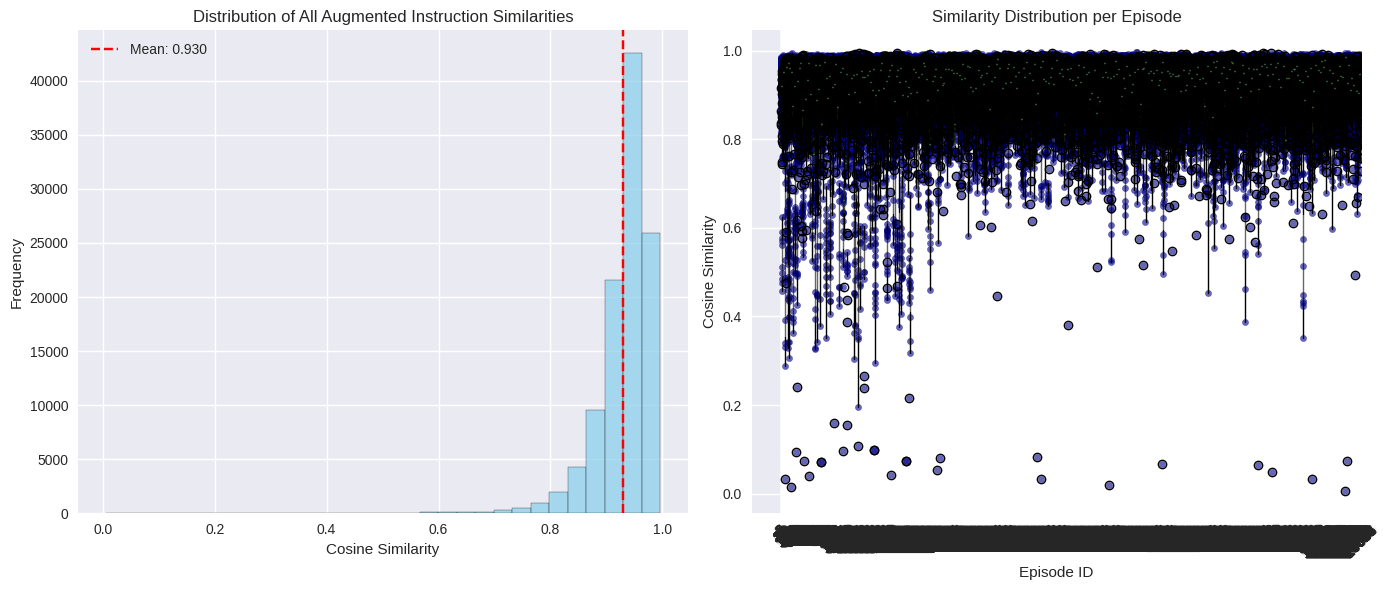

In [1]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
import os

# ----------------------------
# 配置
# ----------------------------
INPUT_FILE = "data/l2am_r2r_v3/train_augmented_instructions.json"
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"  # 注意：这是 HF 上的名称
HF_CACHE_DIR = "data/hf_model_cache"  # HF 模型缓存路径

# ----------------------------
# 加载数据
# ----------------------------
with open(INPUT_FILE, "r", encoding="utf-8") as f:
    data = json.load(f)

episodes = data["episodes"] if "episodes" in data else data
print(f"✅ Loaded {len(episodes)} episodes.")

# ----------------------------
# 初始化 tokenizer 和 model
# ----------------------------
print("📥 Loading tokenizer and model from Hugging Face...")
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir=HF_CACHE_DIR)
model = AutoModel.from_pretrained(MODEL_NAME, cache_dir=HF_CACHE_DIR).to(device)
model.eval()

# ----------------------------
# Mean Pooling 函数
# ----------------------------
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element: last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

# ----------------------------
# 编码句子函数
# ----------------------------
def encode_sentence(sentence):
    encoded = tokenizer(
        sentence,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        outputs = model(**encoded)
    embeddings = mean_pooling(outputs, encoded["attention_mask"])
    # L2 normalize
    embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
    return embeddings.cpu().numpy()

# ----------------------------
# 计算相似度
# ----------------------------
all_similarities = []
episode_stats = []

for ep in episodes:
    orig = ep["original_instruction"]
    aug_keys = [k for k in ep.keys() if k.startswith("augmented_instruction_")]
    aug_instructions = [ep[k] for k in sorted(aug_keys, key=lambda x: int(x.split('_')[-1]))]

    emb_orig = encode_sentence(orig)  # (1, hidden_dim)
    sims = []

    for aug in aug_instructions:
        emb_aug = encode_sentence(aug)
        # Cosine similarity = dot product (since normalized)
        sim = np.dot(emb_orig, emb_aug.T).item()
        sims.append(sim)

    avg_sim = np.mean(sims)
    all_similarities.extend(sims)
    episode_stats.append({
        "episode_id": ep["episode_id"],
        "avg_similarity": float(avg_sim),
        "similarities": [float(s) for s in sims]
    })

    print(f"Episode {ep['episode_id']}: avg={avg_sim:.4f}, min={min(sims):.4f}, max={max(sims):.4f}")

# ----------------------------
# 总体统计
# ----------------------------
all_similarities = np.array(all_similarities)
print("\n" + "="*50)
print("📊 Overall Similarity Statistics")
print(f"Mean:   {all_similarities.mean():.4f}")
print(f"Std:    {all_similarities.std():.4f}")
print(f"Min:    {all_similarities.min():.4f}")
print(f"Max:    {all_similarities.max():.4f}")
print(f"Count:  {len(all_similarities)} augmented instructions")

# ----------------------------
# 可视化（同前）
# ----------------------------
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram
axes[0].hist(all_similarities, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(all_similarities.mean(), color='red', linestyle='--', label=f'Mean: {all_similarities.mean():.3f}')
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of All Augmented Instruction Similarities')
axes[0].legend()

# Per-episode boxplot + jitter
episode_ids = [s["episode_id"] for s in episode_stats]
similarity_lists = [s["similarities"] for s in episode_stats]

np.random.seed(42)
jittered_x = []
jittered_y = []
for i, sims in enumerate(similarity_lists):
    x_vals = np.full(len(sims), i) + np.random.normal(0, 0.05, len(sims))
    jittered_x.extend(x_vals)
    jittered_y.extend(sims)

axes[1].boxplot(similarity_lists, labels=episode_ids, patch_artist=True,
                boxprops=dict(facecolor='lightgreen', alpha=0.6))
axes[1].scatter(jittered_x, jittered_y, color='darkblue', alpha=0.6, s=20)
axes[1].set_xlabel('Episode ID')
axes[1].set_ylabel('Cosine Similarity')
axes[1].set_title('Similarity Distribution per Episode')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("augmented_instruction_similarity_analysis.png", dpi=300, bbox_inches='tight')
print("\n🖼️  Visualization saved as 'augmented_instruction_similarity_analysis.png'")

# Save results
output_results = {
    "overall_stats": {
        "mean": float(all_similarities.mean()),
        "std": float(all_similarities.std()),
        "min": float(all_similarities.min()),
        "max": float(all_similarities.max()),
        "total_count": int(len(all_similarities))
    },
    "per_episode": episode_stats
}

with open("similarity_evaluation_results.json", "w", encoding="utf-8") as f:
    json.dump(output_results, f, indent=2, ensure_ascii=False)

print("💾 Detailed results saved to 'similarity_evaluation_results.json'")

# 分析相似性，并过滤掉地相似度的增强指令保存为新数据

## 过滤 0.8 以下的

/mnt/slurmfs-4090node1/homes/dpeng108/miniforge3/envs/env_transformer_eval/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Loaded 10819 episodes.
📥 Loading tokenizer and model from Hugging Face...
Episode 1: avg=0.9363, kept 10/10 instructions
Episode 2: avg=0.9007, kept 10/10 instructions
Episode 3: avg=0.9536, kept 10/10 instructions
Episode 4: avg=0.9472, kept 10/10 instructions
Episode 5: avg=0.9198, kept 10/10 instructions
Episode 6: avg=0.9619, kept 10/10 instructions
Episode 7: avg=0.9491, kept 10/10 instructions
Episode 8: avg=0.9453, kept 10/10 instructions
Episode 9: avg=0.9427, kept 10/10 instructions
Episode 10: avg=0.9621, kept 10/10 instructions
Episode 11: avg=0.9362, kept 10/10 instructions
Episode 12: avg=0.9149, kept 10/10 instructions
Episode 13: avg=0.9014, kept 9/10 instructions
Episode 14: avg=0.8920, kept 10/10 instructions
Episode 15: avg=0.9646, kept 10/10 instructions
Episode 16: avg=0.9184, kept 10/10 instructions
Episode 17: avg=0.9541, kept 10/10 instructions
Episode 18: avg=0.8927, kept 10/10 instructions
Episode 19: avg=0.9495, kept 10/10 instructions
Episode 20: avg=0.9429

/tmp/ipykernel_646722/1391792897.py:189: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(similarity_lists, labels=episode_ids, patch_artist=True,


🖼️  Visualization saved as: data/l2am_r2r_v3/augmented_instruction_similarity_analysis_0.8.png
📈 Filtering stats saved to: data/l2am_r2r_v3/train_augmented_instructions_filtering_0.8_stats.json

🎉 All tasks completed!


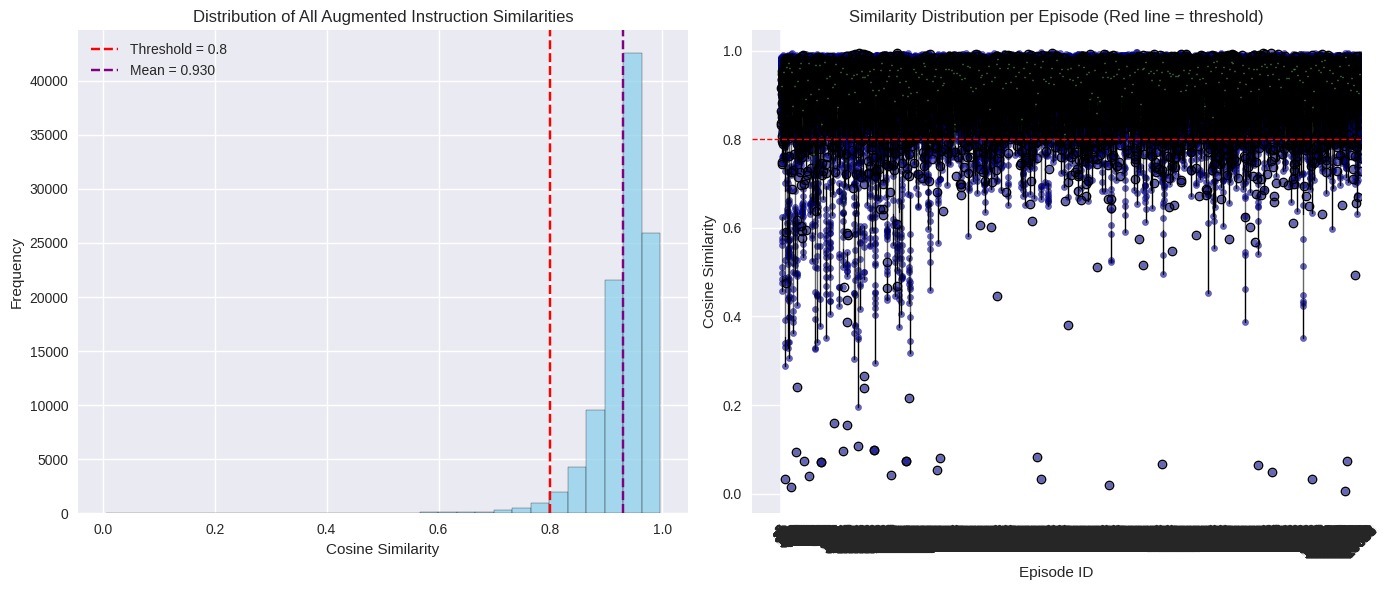

In [1]:
import json
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel

# ----------------------------
# 配置
# ----------------------------
THRESHOLD = 0.8
INPUT_FILE = "data/l2am_r2r_v3/train_augmented_instructions.json"
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"  # 注意：这是 HF 上的名称
HF_CACHE_DIR = "data/hf_model_cache"  # HF 模型缓存路径

input_dir = os.path.dirname(INPUT_FILE) or "."
OUTPUT_FILTERED_FILE = os.path.join(input_dir, f"train_augmented_instructions_filtered_{THRESHOLD}.json")
OUTPUT_FILTERED_OUT_FILE = os.path.join(input_dir, f"train_augmented_instructions_filtered_{THRESHOLD}_out_instructions.json")
VIZ_FILE = os.path.join(input_dir, f"augmented_instruction_similarity_analysis_{THRESHOLD}.png")
STATS_FILE = os.path.join(input_dir, f"train_augmented_instructions_filtering_{THRESHOLD}_stats.json")


# ----------------------------
# 加载数据
# ----------------------------
with open(INPUT_FILE, "r", encoding="utf-8") as f:
    data = json.load(f)

episodes = data["episodes"] if "episodes" in data else data
print(f"✅ Loaded {len(episodes)} episodes.")

# ----------------------------
# 初始化模型
# ----------------------------
print("📥 Loading tokenizer and model from Hugging Face...")
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir=HF_CACHE_DIR)
model = AutoModel.from_pretrained(MODEL_NAME, cache_dir=HF_CACHE_DIR).to(device)
model.eval()

# ----------------------------
# 编码函数
# ----------------------------
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def encode_sentence(sentence):
    encoded = tokenizer(
        sentence,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        outputs = model(**encoded)
    embeddings = mean_pooling(outputs, encoded["attention_mask"])
    embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
    return embeddings.cpu().numpy()

# ----------------------------
# 处理 episodes + 收集被过滤项
# ----------------------------
all_similarities = []
filtered_episodes = []
filtered_out_list = []  # 存储被过滤的指令

for ep in episodes:
    orig_instr = ep["original_instruction"]
    aug_keys = [k for k in ep.keys() if k.startswith("augmented_instruction_")]
    aug_keys_sorted = sorted(aug_keys, key=lambda x: int(x.split('_')[-1]))
    
    emb_orig = encode_sentence(orig_instr)
    kept_aug = {}
    filtered_out_local = []

    sims = []
    for key in aug_keys_sorted:
        aug_instr = ep[key]
        emb_aug = encode_sentence(aug_instr)
        sim = np.dot(emb_orig, emb_aug.T).item()
        sims.append(sim)
        all_similarities.append(sim)
        
        if sim >= THRESHOLD:
            kept_aug[key] = aug_instr
        else:
            filtered_out_local.append({
                "instruction_key": key,
                "instruction_text": aug_instr,
                "similarity": float(sim)
            })

    # 构建过滤后 episode
    filtered_ep = {
        "episode_id": ep["episode_id"],
        "original_instruction": orig_instr,
        **kept_aug
    }
    filtered_episodes.append(filtered_ep)

    # 记录被过滤的（即使为空也记录，便于追踪）
    if filtered_out_local:
        filtered_out_list.append({
            "episode_id": ep["episode_id"],
            "original_instruction": orig_instr,
            "filtered_out_instructions": filtered_out_local
        })

    avg_sim = np.mean(sims)
    print(f"Episode {ep['episode_id']}: "
          f"avg={avg_sim:.4f}, kept {len(kept_aug)}/{len(aug_keys)} instructions")

# ----------------------------
# 按保留数量排序（降序）
# ----------------------------
filtered_episodes.sort(key=lambda x: sum(1 for k in x.keys() if k.startswith("augmented_instruction_")), reverse=True)

# ----------------------------
# 总体统计
# ----------------------------
all_similarities = np.array(all_similarities)
total_original = len(all_similarities)
kept_count = np.sum(all_similarities >= THRESHOLD)
kept_ratio = kept_count / total_original

print("\n" + "="*50)
print("📊 Overall Similarity Statistics")
print(f"Mean:   {all_similarities.mean():.4f}")
print(f"Std:    {all_similarities.std():.4f}")
print(f"Min:    {all_similarities.min():.4f}")
print(f"Max:    {all_similarities.max():.4f}")
print(f"Total augmented instructions: {total_original}")
print(f"Kept:   {int(kept_count)} ({100 * kept_ratio:.1f}%)")
print(f"Filtered out: {int(total_original - kept_count)}")

# ----------------------------
# 保存过滤后的数据（已排序）
# ----------------------------
output_data = {"episodes": filtered_episodes}
with open(OUTPUT_FILTERED_FILE, "w", encoding="utf-8") as f:
    json.dump(output_data, f, indent=2, ensure_ascii=False)
print(f"\n✅ Filtered (and sorted) dataset saved to: {OUTPUT_FILTERED_FILE}")

# ----------------------------
# 保存被过滤的指令
# ----------------------------
with open(OUTPUT_FILTERED_OUT_FILE, "w", encoding="utf-8") as f:
    json.dump(filtered_out_list, f, indent=2, ensure_ascii=False)
print(f"🗑️  Filtered-out instructions saved to: {OUTPUT_FILTERED_OUT_FILE}")

# ----------------------------
# 可视化
# ----------------------------
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram
axes[0].hist(all_similarities, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(THRESHOLD, color='red', linestyle='--', label=f'Threshold = {THRESHOLD}')
axes[0].axvline(all_similarities.mean(), color='purple', linestyle='--', label=f'Mean = {all_similarities.mean():.3f}')
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of All Augmented Instruction Similarities')
axes[0].legend()

# Per-episode boxplot
episode_ids = [ep["episode_id"] for ep in episodes]
similarity_lists = []
idx = 0
for ep in episodes:
    n_aug = len([k for k in ep.keys() if k.startswith("augmented_instruction_")])
    similarity_lists.append(all_similarities[idx:idx+n_aug])
    idx += n_aug

np.random.seed(42)
jittered_x = []
jittered_y = []
for i, sims in enumerate(similarity_lists):
    x_vals = np.full(len(sims), i) + np.random.normal(0, 0.05, len(sims))
    jittered_x.extend(x_vals)
    jittered_y.extend(sims)

axes[1].boxplot(similarity_lists, labels=episode_ids, patch_artist=True,
                boxprops=dict(facecolor='lightgreen', alpha=0.6))
axes[1].scatter(jittered_x, jittered_y, color='darkblue', alpha=0.6, s=20)
axes[1].axhline(THRESHOLD, color='red', linestyle='--', linewidth=1)
axes[1].set_xlabel('Episode ID')
axes[1].set_ylabel('Cosine Similarity')
axes[1].set_title('Similarity Distribution per Episode (Red line = threshold)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(VIZ_FILE, dpi=300, bbox_inches='tight')
print(f"🖼️  Visualization saved as: {VIZ_FILE}")

# ----------------------------
# 保存统计信息
# ----------------------------
stats_output = {
    "threshold": THRESHOLD,
    "overall_stats": {
        "mean": float(all_similarities.mean()),
        "std": float(all_similarities.std()),
        "min": float(all_similarities.min()),
        "max": float(all_similarities.max()),
        "total_count": int(total_original),
        "kept_count": int(kept_count),
        "kept_ratio": float(kept_ratio)
    },
    "num_episodes_with_filtered_out": len(filtered_out_list)
}
with open(STATS_FILE, "w", encoding="utf-8") as f:
    json.dump(stats_output, f, indent=2, ensure_ascii=False)
print(f"📈 Filtering stats saved to: {STATS_FILE}")

print("\n🎉 All tasks completed!")

## 过滤 0.7 以下的

✅ Loaded 10819 episodes.
📥 Loading tokenizer and model from Hugging Face...
Episode 1: avg=0.9363, kept 10/10 instructions
Episode 2: avg=0.9007, kept 10/10 instructions
Episode 3: avg=0.9536, kept 10/10 instructions
Episode 4: avg=0.9472, kept 10/10 instructions
Episode 5: avg=0.9198, kept 10/10 instructions
Episode 6: avg=0.9619, kept 10/10 instructions
Episode 7: avg=0.9491, kept 10/10 instructions
Episode 8: avg=0.9453, kept 10/10 instructions
Episode 9: avg=0.9427, kept 10/10 instructions
Episode 10: avg=0.9621, kept 10/10 instructions
Episode 11: avg=0.9362, kept 10/10 instructions
Episode 12: avg=0.9149, kept 10/10 instructions
Episode 13: avg=0.9014, kept 10/10 instructions
Episode 14: avg=0.8920, kept 10/10 instructions
Episode 15: avg=0.9646, kept 10/10 instructions
Episode 16: avg=0.9184, kept 10/10 instructions
Episode 17: avg=0.9541, kept 10/10 instructions
Episode 18: avg=0.8927, kept 10/10 instructions
Episode 19: avg=0.9495, kept 10/10 instructions
Episode 20: avg=0.942

/tmp/ipykernel_646722/3170630728.py:189: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(similarity_lists, labels=episode_ids, patch_artist=True,


🖼️  Visualization saved as: data/l2am_r2r_v3/augmented_instruction_similarity_analysis_0.7.png
📈 Filtering stats saved to: data/l2am_r2r_v3/train_augmented_instructions_filtering_0.7_stats.json

🎉 All tasks completed!


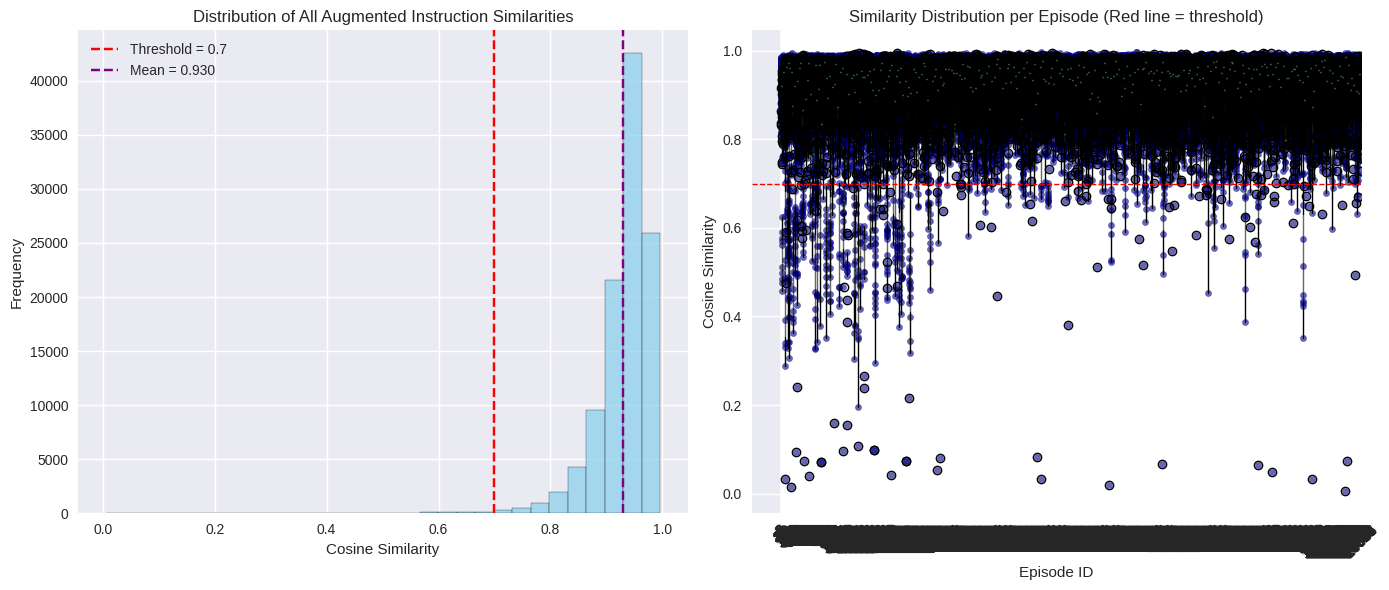

: 

In [ ]:
import json
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel

# ----------------------------
# 配置
# ----------------------------
THRESHOLD = 0.7
INPUT_FILE = "data/l2am_r2r_v3/train_augmented_instructions.json"
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"  # 注意：这是 HF 上的名称
HF_CACHE_DIR = "data/hf_model_cache"  # HF 模型缓存路径

input_dir = os.path.dirname(INPUT_FILE) or "."
OUTPUT_FILTERED_FILE = os.path.join(input_dir, f"train_augmented_instructions_filtered_{THRESHOLD}.json")
OUTPUT_FILTERED_OUT_FILE = os.path.join(input_dir, f"train_augmented_instructions_filtered_{THRESHOLD}_out_instructions.json")
VIZ_FILE = os.path.join(input_dir, f"augmented_instruction_similarity_analysis_{THRESHOLD}.png")
STATS_FILE = os.path.join(input_dir, f"train_augmented_instructions_filtering_{THRESHOLD}_stats.json")


# ----------------------------
# 加载数据
# ----------------------------
with open(INPUT_FILE, "r", encoding="utf-8") as f:
    data = json.load(f)

episodes = data["episodes"] if "episodes" in data else data
print(f"✅ Loaded {len(episodes)} episodes.")

# ----------------------------
# 初始化模型
# ----------------------------
print("📥 Loading tokenizer and model from Hugging Face...")
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir=HF_CACHE_DIR)
model = AutoModel.from_pretrained(MODEL_NAME, cache_dir=HF_CACHE_DIR).to(device)
model.eval()

# ----------------------------
# 编码函数
# ----------------------------
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def encode_sentence(sentence):
    encoded = tokenizer(
        sentence,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        outputs = model(**encoded)
    embeddings = mean_pooling(outputs, encoded["attention_mask"])
    embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
    return embeddings.cpu().numpy()

# ----------------------------
# 处理 episodes + 收集被过滤项
# ----------------------------
all_similarities = []
filtered_episodes = []
filtered_out_list = []  # 存储被过滤的指令

for ep in episodes:
    orig_instr = ep["original_instruction"]
    aug_keys = [k for k in ep.keys() if k.startswith("augmented_instruction_")]
    aug_keys_sorted = sorted(aug_keys, key=lambda x: int(x.split('_')[-1]))
    
    emb_orig = encode_sentence(orig_instr)
    kept_aug = {}
    filtered_out_local = []

    sims = []
    for key in aug_keys_sorted:
        aug_instr = ep[key]
        emb_aug = encode_sentence(aug_instr)
        sim = np.dot(emb_orig, emb_aug.T).item()
        sims.append(sim)
        all_similarities.append(sim)
        
        if sim >= THRESHOLD:
            kept_aug[key] = aug_instr
        else:
            filtered_out_local.append({
                "instruction_key": key,
                "instruction_text": aug_instr,
                "similarity": float(sim)
            })

    # 构建过滤后 episode
    filtered_ep = {
        "episode_id": ep["episode_id"],
        "original_instruction": orig_instr,
        **kept_aug
    }
    filtered_episodes.append(filtered_ep)

    # 记录被过滤的（即使为空也记录，便于追踪）
    if filtered_out_local:
        filtered_out_list.append({
            "episode_id": ep["episode_id"],
            "original_instruction": orig_instr,
            "filtered_out_instructions": filtered_out_local
        })

    avg_sim = np.mean(sims)
    print(f"Episode {ep['episode_id']}: "
          f"avg={avg_sim:.4f}, kept {len(kept_aug)}/{len(aug_keys)} instructions")

# ----------------------------
# 按保留数量排序（降序）
# ----------------------------
filtered_episodes.sort(key=lambda x: sum(1 for k in x.keys() if k.startswith("augmented_instruction_")), reverse=True)

# ----------------------------
# 总体统计
# ----------------------------
all_similarities = np.array(all_similarities)
total_original = len(all_similarities)
kept_count = np.sum(all_similarities >= THRESHOLD)
kept_ratio = kept_count / total_original

print("\n" + "="*50)
print("📊 Overall Similarity Statistics")
print(f"Mean:   {all_similarities.mean():.4f}")
print(f"Std:    {all_similarities.std():.4f}")
print(f"Min:    {all_similarities.min():.4f}")
print(f"Max:    {all_similarities.max():.4f}")
print(f"Total augmented instructions: {total_original}")
print(f"Kept:   {int(kept_count)} ({100 * kept_ratio:.1f}%)")
print(f"Filtered out: {int(total_original - kept_count)}")

# ----------------------------
# 保存过滤后的数据（已排序）
# ----------------------------
output_data = {"episodes": filtered_episodes}
with open(OUTPUT_FILTERED_FILE, "w", encoding="utf-8") as f:
    json.dump(output_data, f, indent=2, ensure_ascii=False)
print(f"\n✅ Filtered (and sorted) dataset saved to: {OUTPUT_FILTERED_FILE}")

# ----------------------------
# 保存被过滤的指令
# ----------------------------
with open(OUTPUT_FILTERED_OUT_FILE, "w", encoding="utf-8") as f:
    json.dump(filtered_out_list, f, indent=2, ensure_ascii=False)
print(f"🗑️  Filtered-out instructions saved to: {OUTPUT_FILTERED_OUT_FILE}")

# ----------------------------
# 可视化
# ----------------------------
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram
axes[0].hist(all_similarities, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(THRESHOLD, color='red', linestyle='--', label=f'Threshold = {THRESHOLD}')
axes[0].axvline(all_similarities.mean(), color='purple', linestyle='--', label=f'Mean = {all_similarities.mean():.3f}')
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of All Augmented Instruction Similarities')
axes[0].legend()

# Per-episode boxplot
episode_ids = [ep["episode_id"] for ep in episodes]
similarity_lists = []
idx = 0
for ep in episodes:
    n_aug = len([k for k in ep.keys() if k.startswith("augmented_instruction_")])
    similarity_lists.append(all_similarities[idx:idx+n_aug])
    idx += n_aug

np.random.seed(42)
jittered_x = []
jittered_y = []
for i, sims in enumerate(similarity_lists):
    x_vals = np.full(len(sims), i) + np.random.normal(0, 0.05, len(sims))
    jittered_x.extend(x_vals)
    jittered_y.extend(sims)

axes[1].boxplot(similarity_lists, labels=episode_ids, patch_artist=True,
                boxprops=dict(facecolor='lightgreen', alpha=0.6))
axes[1].scatter(jittered_x, jittered_y, color='darkblue', alpha=0.6, s=20)
axes[1].axhline(THRESHOLD, color='red', linestyle='--', linewidth=1)
axes[1].set_xlabel('Episode ID')
axes[1].set_ylabel('Cosine Similarity')
axes[1].set_title('Similarity Distribution per Episode (Red line = threshold)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(VIZ_FILE, dpi=300, bbox_inches='tight')
print(f"🖼️  Visualization saved as: {VIZ_FILE}")

# ----------------------------
# 保存统计信息
# ----------------------------
stats_output = {
    "threshold": THRESHOLD,
    "overall_stats": {
        "mean": float(all_similarities.mean()),
        "std": float(all_similarities.std()),
        "min": float(all_similarities.min()),
        "max": float(all_similarities.max()),
        "total_count": int(total_original),
        "kept_count": int(kept_count),
        "kept_ratio": float(kept_ratio)
    },
    "num_episodes_with_filtered_out": len(filtered_out_list)
}
with open(STATS_FILE, "w", encoding="utf-8") as f:
    json.dump(stats_output, f, indent=2, ensure_ascii=False)
print(f"📈 Filtering stats saved to: {STATS_FILE}")

print("\n🎉 All tasks completed!")

## 过滤 0.6 以下的

/mnt/slurmfs-4090node1/homes/dpeng108/miniforge3/envs/env_transformer_eval/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Loaded 10819 episodes.
📥 Loading tokenizer and model from Hugging Face...
Episode 1: avg=0.9363, kept 10/10 instructions
Episode 2: avg=0.9007, kept 10/10 instructions
Episode 3: avg=0.9536, kept 10/10 instructions
Episode 4: avg=0.9472, kept 10/10 instructions
Episode 5: avg=0.9198, kept 10/10 instructions
Episode 6: avg=0.9619, kept 10/10 instructions
Episode 7: avg=0.9491, kept 10/10 instructions
Episode 8: avg=0.9453, kept 10/10 instructions
Episode 9: avg=0.9427, kept 10/10 instructions
Episode 10: avg=0.9621, kept 10/10 instructions
Episode 11: avg=0.9362, kept 10/10 instructions
Episode 12: avg=0.9149, kept 10/10 instructions
Episode 13: avg=0.9014, kept 10/10 instructions
Episode 14: avg=0.8920, kept 10/10 instructions
Episode 15: avg=0.9646, kept 10/10 instructions
Episode 16: avg=0.9184, kept 10/10 instructions
Episode 17: avg=0.9541, kept 10/10 instructions
Episode 18: avg=0.8927, kept 10/10 instructions
Episode 19: avg=0.9495, kept 10/10 instructions
Episode 20: avg=0.942

/tmp/ipykernel_631442/3517302755.py:189: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(similarity_lists, labels=episode_ids, patch_artist=True,


🖼️  Visualization saved as: data/l2am_r2r_v3/augmented_instruction_similarity_analysis_0.6.png
📈 Filtering stats saved to: data/l2am_r2r_v3/train_augmented_instructions_filtering_0.6_stats.json

🎉 All tasks completed!


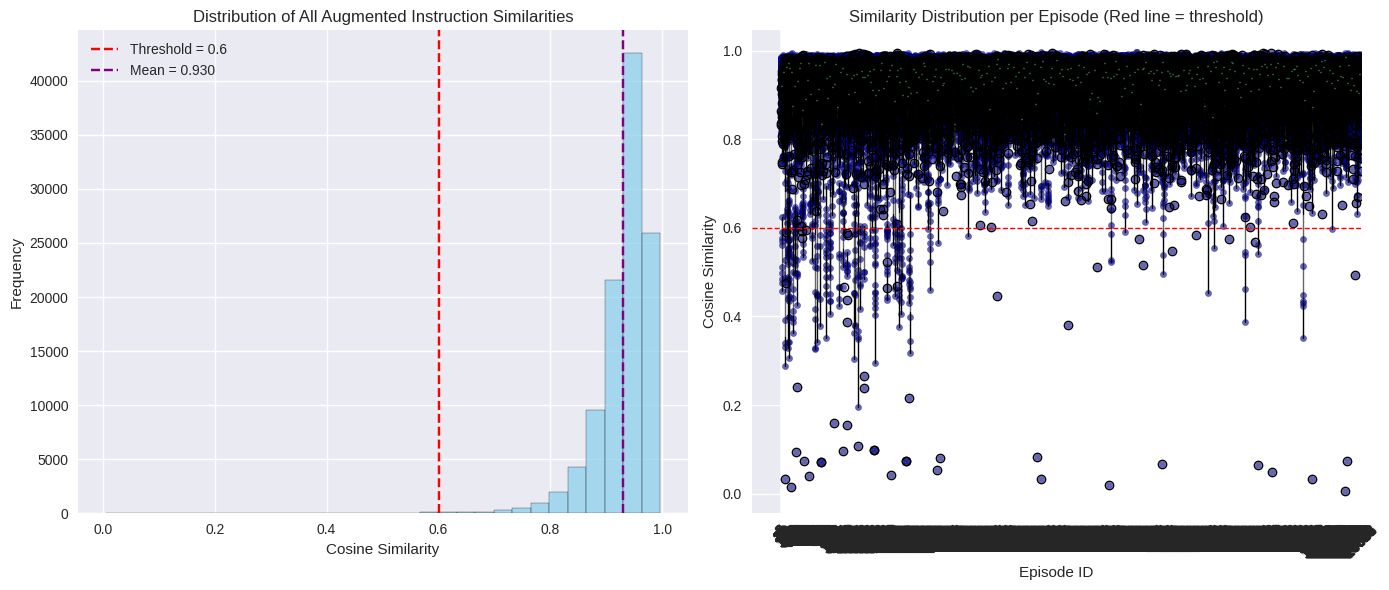

In [1]:
import json
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel

# ----------------------------
# 配置
# ----------------------------
THRESHOLD = 0.6
INPUT_FILE = "data/l2am_r2r_v3/train_augmented_instructions.json"
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"  # 注意：这是 HF 上的名称
HF_CACHE_DIR = "data/hf_model_cache"  # HF 模型缓存路径

input_dir = os.path.dirname(INPUT_FILE) or "."
OUTPUT_FILTERED_FILE = os.path.join(input_dir, f"train_augmented_instructions_filtered_{THRESHOLD}.json")
OUTPUT_FILTERED_OUT_FILE = os.path.join(input_dir, f"train_augmented_instructions_filtered_{THRESHOLD}_out_instructions.json")
VIZ_FILE = os.path.join(input_dir, f"augmented_instruction_similarity_analysis_{THRESHOLD}.png")
STATS_FILE = os.path.join(input_dir, f"train_augmented_instructions_filtering_{THRESHOLD}_stats.json")


# ----------------------------
# 加载数据
# ----------------------------
with open(INPUT_FILE, "r", encoding="utf-8") as f:
    data = json.load(f)

episodes = data["episodes"] if "episodes" in data else data
print(f"✅ Loaded {len(episodes)} episodes.")

# ----------------------------
# 初始化模型
# ----------------------------
print("📥 Loading tokenizer and model from Hugging Face...")
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir=HF_CACHE_DIR)
model = AutoModel.from_pretrained(MODEL_NAME, cache_dir=HF_CACHE_DIR).to(device)
model.eval()

# ----------------------------
# 编码函数
# ----------------------------
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def encode_sentence(sentence):
    encoded = tokenizer(
        sentence,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        outputs = model(**encoded)
    embeddings = mean_pooling(outputs, encoded["attention_mask"])
    embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
    return embeddings.cpu().numpy()

# ----------------------------
# 处理 episodes + 收集被过滤项
# ----------------------------
all_similarities = []
filtered_episodes = []
filtered_out_list = []  # 存储被过滤的指令

for ep in episodes:
    orig_instr = ep["original_instruction"]
    aug_keys = [k for k in ep.keys() if k.startswith("augmented_instruction_")]
    aug_keys_sorted = sorted(aug_keys, key=lambda x: int(x.split('_')[-1]))
    
    emb_orig = encode_sentence(orig_instr)
    kept_aug = {}
    filtered_out_local = []

    sims = []
    for key in aug_keys_sorted:
        aug_instr = ep[key]
        emb_aug = encode_sentence(aug_instr)
        sim = np.dot(emb_orig, emb_aug.T).item()
        sims.append(sim)
        all_similarities.append(sim)
        
        if sim >= THRESHOLD:
            kept_aug[key] = aug_instr
        else:
            filtered_out_local.append({
                "instruction_key": key,
                "instruction_text": aug_instr,
                "similarity": float(sim)
            })

    # 构建过滤后 episode
    filtered_ep = {
        "episode_id": ep["episode_id"],
        "original_instruction": orig_instr,
        **kept_aug
    }
    filtered_episodes.append(filtered_ep)

    # 记录被过滤的（即使为空也记录，便于追踪）
    if filtered_out_local:
        filtered_out_list.append({
            "episode_id": ep["episode_id"],
            "original_instruction": orig_instr,
            "filtered_out_instructions": filtered_out_local
        })

    avg_sim = np.mean(sims)
    print(f"Episode {ep['episode_id']}: "
          f"avg={avg_sim:.4f}, kept {len(kept_aug)}/{len(aug_keys)} instructions")

# ----------------------------
# 按保留数量排序（降序）
# ----------------------------
filtered_episodes.sort(key=lambda x: sum(1 for k in x.keys() if k.startswith("augmented_instruction_")), reverse=True)

# ----------------------------
# 总体统计
# ----------------------------
all_similarities = np.array(all_similarities)
total_original = len(all_similarities)
kept_count = np.sum(all_similarities >= THRESHOLD)
kept_ratio = kept_count / total_original

print("\n" + "="*50)
print("📊 Overall Similarity Statistics")
print(f"Mean:   {all_similarities.mean():.4f}")
print(f"Std:    {all_similarities.std():.4f}")
print(f"Min:    {all_similarities.min():.4f}")
print(f"Max:    {all_similarities.max():.4f}")
print(f"Total augmented instructions: {total_original}")
print(f"Kept:   {int(kept_count)} ({100 * kept_ratio:.1f}%)")
print(f"Filtered out: {int(total_original - kept_count)}")

# ----------------------------
# 保存过滤后的数据（已排序）
# ----------------------------
output_data = {"episodes": filtered_episodes}
with open(OUTPUT_FILTERED_FILE, "w", encoding="utf-8") as f:
    json.dump(output_data, f, indent=2, ensure_ascii=False)
print(f"\n✅ Filtered (and sorted) dataset saved to: {OUTPUT_FILTERED_FILE}")

# ----------------------------
# 保存被过滤的指令
# ----------------------------
with open(OUTPUT_FILTERED_OUT_FILE, "w", encoding="utf-8") as f:
    json.dump(filtered_out_list, f, indent=2, ensure_ascii=False)
print(f"🗑️  Filtered-out instructions saved to: {OUTPUT_FILTERED_OUT_FILE}")

# ----------------------------
# 可视化
# ----------------------------
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram
axes[0].hist(all_similarities, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(THRESHOLD, color='red', linestyle='--', label=f'Threshold = {THRESHOLD}')
axes[0].axvline(all_similarities.mean(), color='purple', linestyle='--', label=f'Mean = {all_similarities.mean():.3f}')
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of All Augmented Instruction Similarities')
axes[0].legend()

# Per-episode boxplot
episode_ids = [ep["episode_id"] for ep in episodes]
similarity_lists = []
idx = 0
for ep in episodes:
    n_aug = len([k for k in ep.keys() if k.startswith("augmented_instruction_")])
    similarity_lists.append(all_similarities[idx:idx+n_aug])
    idx += n_aug

np.random.seed(42)
jittered_x = []
jittered_y = []
for i, sims in enumerate(similarity_lists):
    x_vals = np.full(len(sims), i) + np.random.normal(0, 0.05, len(sims))
    jittered_x.extend(x_vals)
    jittered_y.extend(sims)

axes[1].boxplot(similarity_lists, labels=episode_ids, patch_artist=True,
                boxprops=dict(facecolor='lightgreen', alpha=0.6))
axes[1].scatter(jittered_x, jittered_y, color='darkblue', alpha=0.6, s=20)
axes[1].axhline(THRESHOLD, color='red', linestyle='--', linewidth=1)
axes[1].set_xlabel('Episode ID')
axes[1].set_ylabel('Cosine Similarity')
axes[1].set_title('Similarity Distribution per Episode (Red line = threshold)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(VIZ_FILE, dpi=300, bbox_inches='tight')
print(f"🖼️  Visualization saved as: {VIZ_FILE}")

# ----------------------------
# 保存统计信息
# ----------------------------
stats_output = {
    "threshold": THRESHOLD,
    "overall_stats": {
        "mean": float(all_similarities.mean()),
        "std": float(all_similarities.std()),
        "min": float(all_similarities.min()),
        "max": float(all_similarities.max()),
        "total_count": int(total_original),
        "kept_count": int(kept_count),
        "kept_ratio": float(kept_ratio)
    },
    "num_episodes_with_filtered_out": len(filtered_out_list)
}
with open(STATS_FILE, "w", encoding="utf-8") as f:
    json.dump(stats_output, f, indent=2, ensure_ascii=False)
print(f"📈 Filtering stats saved to: {STATS_FILE}")

print("\n🎉 All tasks completed!")